# Chapter 2. Training Machine Learning Algorithms for Classication.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

![Iris](http://www.canadianflowerdelivery.com/assets/images/content/iris_195x195.jpg)

We will use `Perceptron` algorithm for binary classification problem, based on Iris dataset.

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [3]:
df.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Dataset Descripion

* **Column 0** - x0 sepal length 
* **Column 2** - x1 petal lenght
* **Column 4** - y class of flower (label)

The feature vector `x` would contain of only two features: `sepal length` and `petal length`.

### Dataset Preparation and Visualization

Let's plot features on 2D graph.

In [4]:
# prepare labels array
y = df.iloc[0:100, 4].values
# transform label array from text to [-1, 1] values
y_train = np.where(y == 'Iris-setosa', -1, 1)

In [5]:
# prepare feature matrix
X_train = df.iloc[0:100, [0, 2]].values

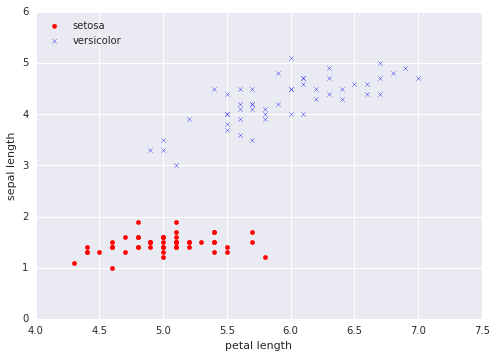

In [6]:
# prepare visualization
plt.scatter(X_train[:50, 0], X_train[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X_train[50:100, 0], X_train[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('petal length')
plt.ylabel('sepal length')
plt.legend(loc='upper left')
plt.show()

From the plot we can see, that classes are *linearly separable*, so we can apply **Perceptron** model.

## Perceptron

Let's implement simple percepton model.

In [7]:
def activation_function(z):
    return np.where(z >= 0, 1, -1)

def add_bias_column(X):
    (m, n) = X.shape
    X = np.concatenate((np.ones((m, 1)), X), 1)
    return X
    
def perceptron(X, w):
    X = add_bias_column(X)
    z = np.dot(X, w)
            
    return activation_function(z)

Try it with a randomly generated weights:

In [8]:
def random_weights(features_dimention):
    return np.random.rand(1 + features_dimention) / 32

def zero_weights(features_dimention):
    return np.zeros(1 + features_dimention)

w_random = random_weights(2)

print('random small weights', w_random)

random small weights [ 0.01829631  0.03121418  0.02712658]


Run perceptron and check it's current predictions:

In [9]:
prediction = perceptron(X_train, w_random)
print(prediction)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


As you can see, current classifier predicts everything as `virginica`, which is not true. Let's introduce some functions, we can measure errors and accuracy of classifirer:

In [10]:
def error(predicted, expected):
    return np.subtract(predicted, expected)

def error_count(predicted, expected):
    return np.count_nonzero(error(predicted, expected))

def minimal_square_error(predicted, expected):
    m = predicted.size
    return (np.sum(np.power(np.subtract(predicted, expected), 2)) / 2 * (m))

def classifier_accuracy(predicted, expected):
    m = predicted.size
    return error_count(predicted, expected) / m

### Misclassified samples

In [11]:
print(error_count(prediction, y_train))

50


### Minimal squares error

In [12]:
print(minimal_square_error(prediction, y_train))

10000.0


### Classifier accuracy

In [13]:
print(classifier_accuracy(prediction, y_train))

0.5


## Perceptron Training

As we can see from figures above, the performance on given model is very low. Our goal, is to adjust model parameters `w`, for better classification results. The learning algorithm is based on adjustion of `weights` after training session, based on error given by classifier.

\begin{align}
&\omega_j := \omega_j  + \Delta\omega_j
\end{align}

\begin{align}
&\Delta\omega_j := \alpha (y^i - \hat{y}^i) x_j^j
\end{align}

Where $\alpha$ - is a constant, called learning rate.

We run our training routine until we see good enought prediction results. Each cycle of training is called `epoch`.

In [70]:
def run_perceptron(X, y, w):
    predicted = perceptron(X, w)  
    return (
        w,
        error(y, predicted),
        error_count(y, predicted)
    )

def adjust_weigths(alpha, X, w, error):
    X = add_bias_column(X)
    delta_w = np.dot(np.dot(error, X), alpha)
    
    return np.add(w, delta_w)

def select_model(train_results):
    return [result for result in train_results if result[2] == 0] 

def train(alpha, epochs_count, X, y):
    results = []

    w_local = random_weights(X.shape[1])
    
    for epoch in range(epochs_count):
        result = run_perceptron(X, y, w_local)
        # adjust the model, based on currents results and start next epoch..
        w_local = adjust_weigths(alpha, X, w_local, result[1])            
        results.append(result)
    
    return results

In [57]:
def plot_training_results(results, dim, label):
    errors = list(map(lambda r: r[dim], results))
    
    plt.plot(range(1, len(errors) + 1), errors, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.show()

### Alpha = 0.01, Epochs = 10

[-1.09864798 -2.75477154  6.47015518]


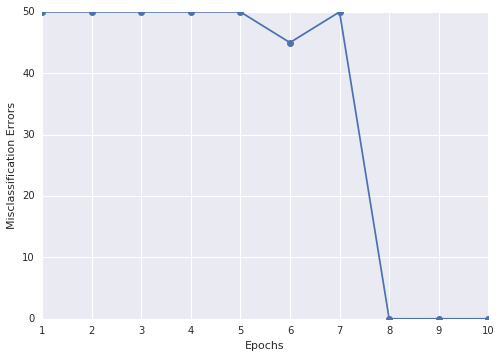

In [71]:
results_1 = train(0.01, 10, X_train, y_train);
model_1 = select_model(results_1)
print(model_1[0][0])

plot_training_results(results_1, 2, 'Misclassification Errors')

### Alpha = 0.03, Epochs = 10

[-10.6  -25.62  66.36]


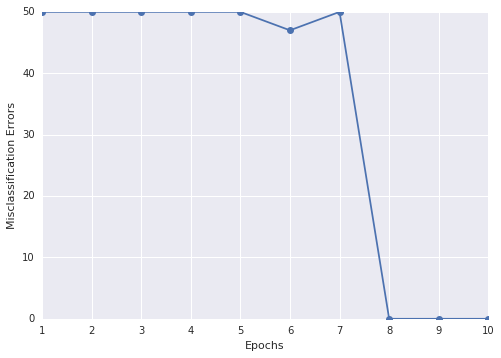

In [73]:
results_2 = train(0.03, 10, X_train, y_train)
model_2 = select_model(results_3)
print(model_2[0][0])

plot_training_results(results_2, 2, 'Misclassification Errors')

## Alpha = 0.1, Epochs = 10

[-10.57715348 -25.60764026  66.39081609]


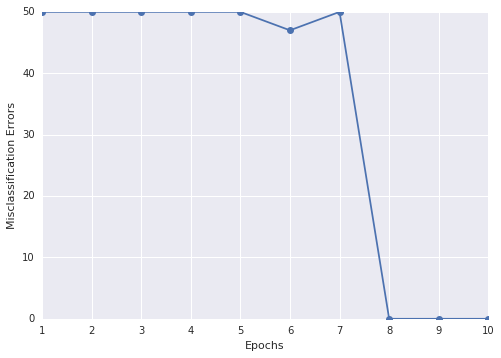

In [76]:
results_3 = train(0.1, 10, X_train, y_train)
model_3 = select_model(results_3)
print(model_3[0][0])

plot_training_results(results_3, 2, 'Misclassification Errors')